<a href="https://colab.research.google.com/github/shiv9thakur/shiv9thakur/blob/main/Deep_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Potato disease classifier
First we will download the dataset into the tf pipeline. Then we will do some data cleaning ,feature engineering (if necessary) and then we will generate model.

## Importing dataset and modules


In [ ]:
import tensorflow as tf
from tensorflow.keras import  models, layers
import matplotlib.pyplot as plt

Using tensorflow dataset to download this in to the tf.data.daatset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [ ]:
# Loading the dataset into the tf pipeline

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    )

Found 2152 files belonging to 5 classes.


## Exploring the the dataset

In [ ]:
class_names = dataset.class_names
class_names

['.ipynb_checkpoints',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'models']

In [ ]:
len(dataset)

68

In [ ]:
# INFO ABOUT THE BATCHES
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[1 2 2 2 2 1 2 1 1 2 1 3 2 2 1 2 1 3 3 2 1 1 2 3 3 1 2 1 2 1 1 2]


In [ ]:
# Lets print the first image array
for image_batch, label_batch in dataset.take(1):
  print(image_batch[0].numpy())

[[[144. 138. 140.]
  [144. 138. 140.]
  [143. 137. 139.]
  ...
  [164. 158. 162.]
  [167. 161. 165.]
  [164. 158. 162.]]

 [[143. 137. 139.]
  [144. 138. 140.]
  [145. 139. 141.]
  ...
  [165. 159. 163.]
  [166. 160. 164.]
  [163. 157. 161.]]

 [[147. 141. 143.]
  [145. 139. 141.]
  [143. 137. 139.]
  ...
  [166. 160. 164.]
  [167. 161. 165.]
  [165. 159. 163.]]

 ...

 [[137. 127. 126.]
  [139. 129. 128.]
  [130. 120. 119.]
  ...
  [133. 127. 131.]
  [159. 153. 157.]
  [136. 130. 134.]]

 [[138. 128. 127.]
  [144. 134. 133.]
  [138. 128. 127.]
  ...
  [156. 150. 154.]
  [152. 146. 150.]
  [152. 146. 150.]]

 [[129. 119. 118.]
  [144. 134. 133.]
  [148. 138. 137.]
  ...
  [150. 144. 148.]
  [164. 158. 162.]
  [123. 117. 121.]]]


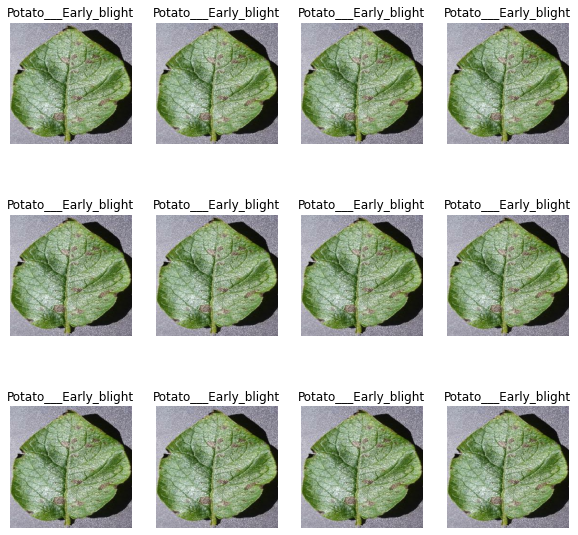

In [ ]:
#Visualizing the images
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.title(class_names[label_batch[0]])
    plt.axis('off')


80% --> training

20% --> 10% for validation, 10% for testing

In [ ]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [ ]:
train_ds = dataset.take(54)
len(train_ds)

54

In [ ]:
trail_ds = dataset.skip(54)
len(trail_ds)

14

In [ ]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [ ]:
val_ds = trail_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds = trail_ds.skip(6)
len(test_ds)

8

In [ ]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle_size = 10000, shuffle=True):
  
  ds_size = len(ds)
  
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 12)
  # Getting the respective size of the dataset
  
  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  #Spliting the dataset
  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
  
  return train_ds,val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

54

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

8

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

## Preprocessing

In [ ]:
resize_and_rescale = tf.keras.Sequential([
                     layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
                     layers.experimental.preprocessing.Rescaling(1.0/255)
])

### Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
                     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                     layers.experimental.preprocessing.RandomRotation(0.2),
                     ])

## Building a CNN

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
                          resize_and_rescale,
                          data_augmentation,
                          layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = input_shape ),
                          layers.MaxPooling2D((2, 2)),
                          layers.Conv2D(64, (3, 3), activation = 'relu'),
                          layers.MaxPooling2D((2, 2)),
                          layers.Conv2D(64, (3, 3), activation = 'relu'),
                          layers.MaxPooling2D((2, 2)),
                          layers.Conv2D(64, (3, 3), activation = 'relu'),
                          layers.MaxPooling2D((2, 2)),
                          layers.Conv2D(64, (3, 3), activation = 'relu'),
                          layers.MaxPooling2D((2, 2)),
                          layers.Flatten(),
                          layers.Dense(64, activation = 'relu'),
                          layers.Dense(n_classes, activation = 'softmax'), # softmax = Normalizes the probability of your classes
])

model.build(input_shape = input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30
)

Epoch 1/30
54/54 [==============================] - 133s 224ms/step - loss: nan - accuracy: 0.0081 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/30
54/54 [==============================] - 6s 120ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/30
54/54 [==============================] - 6s 119ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/30
54/54 [==============================] - 6s 118ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/30
54/54 [==============================] - 6s 119ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 6/30
54/54 [==============================] - 7s 121ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 7/30
54/54 [==============================] - 6s 119ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.000

In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 39ms/step - loss: nan - accuracy: 0.0000e+00


In [ ]:
scores

[nan, 0.0]

In [ ]:
history

In [ ]:
print(history.params)

{'verbose': 1, 'epochs': 30, 'steps': 54}


In [ ]:
print(history.history.keys)

<built-in method keys of dict object at 0x7faed37c2eb0>


## Visualizing the learning curve

In [ ]:
# Storing the history parameters in variables

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

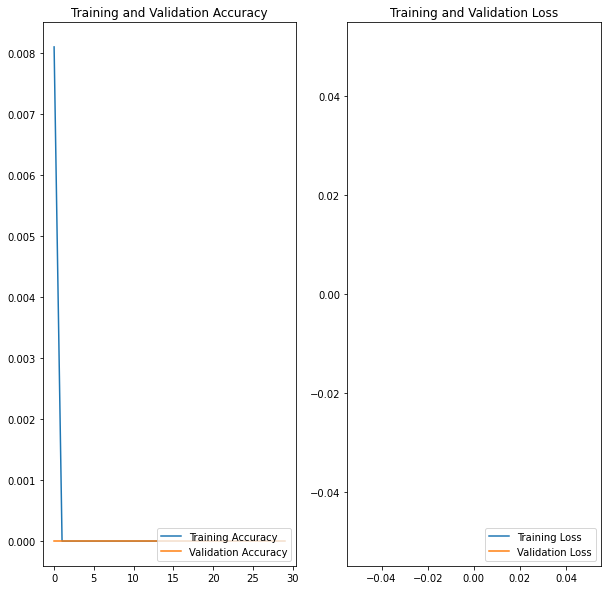

In [ ]:
# Plotting the Training accuracy
plt.figure(figsize = (10, 10))
plt.subplot(1, 2, 1)
plt.plot(range(30), acc, label = 'Training Accuracy')
plt.plot(range(30), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

#Loss Chart
plt.subplot(1, 2, 2)
plt.plot(range(30), loss, label = 'Training Loss')
plt.plot(range(30), val_loss, label = 'Validation Loss')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
Actual label:  Potato___Late_blight
Predicted label:  .ipynb_checkpoints


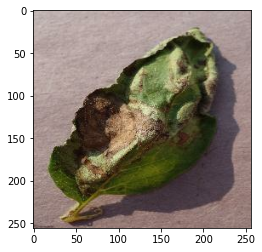

In [ ]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):

  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("Actual label: ", class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("Predicted label: ", class_names[np.argmax(batch_prediction[0])])

In [ ]:
# Function to telling the confidence and prediction of the model

def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0) # Creates a batch

  predictions = model.predict(img_array)

  predict_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predict_class, confidence

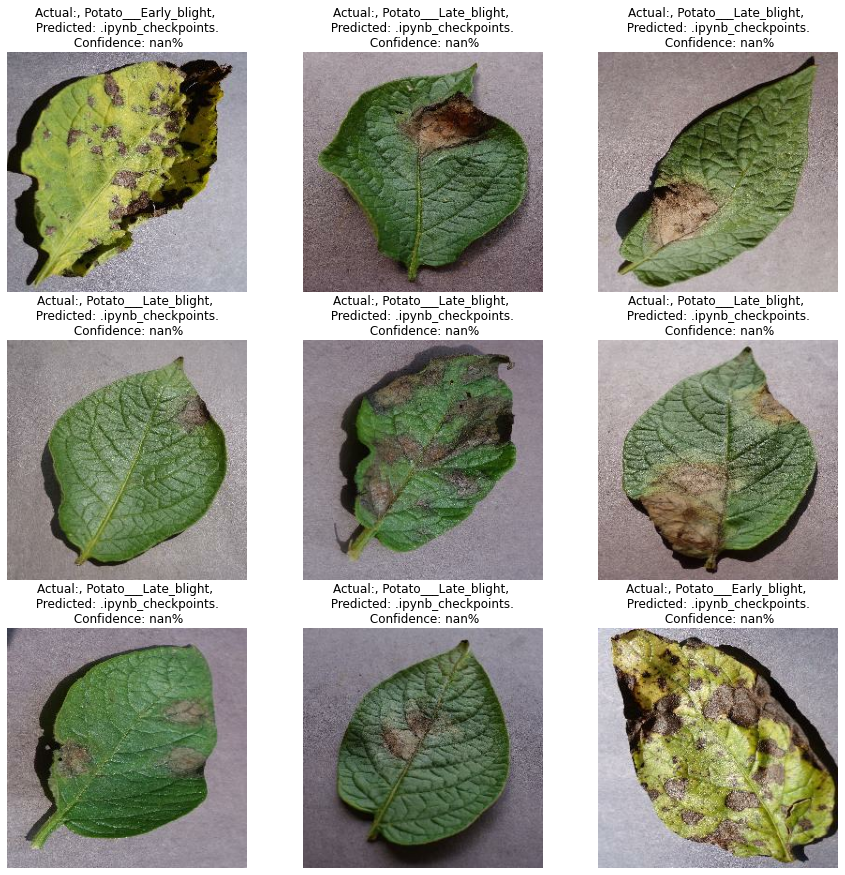

In [ ]:
plt.figure(figsize = (15, 15))

for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    
    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual:, {actual_class}, \n Predicted: {predicted_class}. \n Confidence: {confidence}%")

    plt.axis('off')


In [ ]:
model_version = 1
model.save("model1.h5")

In [ ]:
model.save('saved_model/my_model')